# Analysis
### Table of Contents
- [Requirements](#requirements)
- [Change Point Detection](#change-point-detection)
- [Coercing Stationarity](#coercing-stationarity)
- [Correlation Analysis](#correlation-analysis)

## Requirements

In [70]:
import warnings

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
import darts
import ruptures as rpt

In [71]:
df = pd.read_csv('../../data/clean/clean.csv') # file path appears as `data/clean/clean.csv` in `analysis.py`

## Change Point Detection

In [75]:
n_bkps = 3

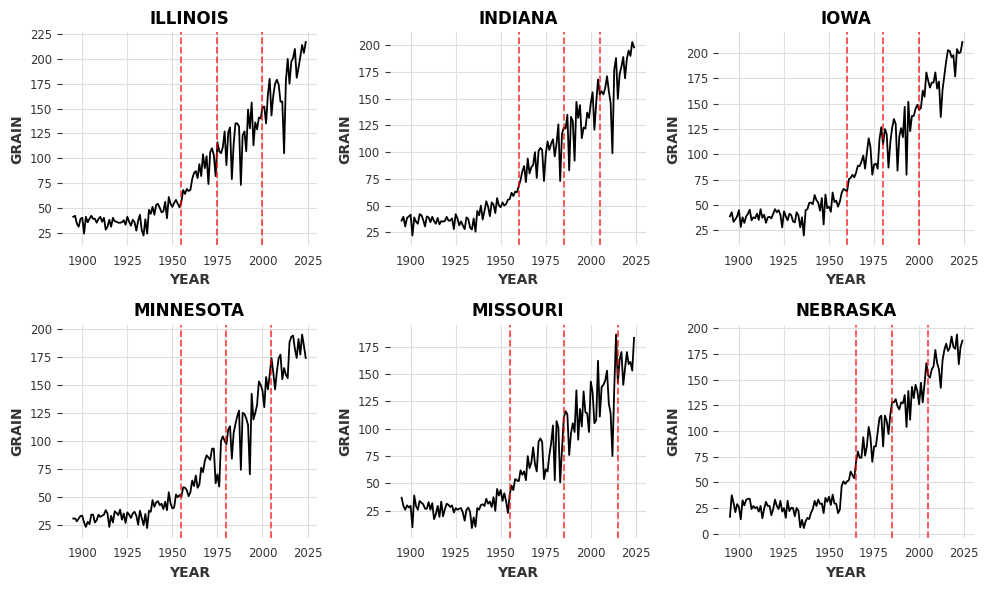

In [76]:
states = df['STATE'].unique()
fig, axes = plt.subplots(nrows=2, ncols=int(np.ceil(len(states)/2)), figsize=(10, 6))

for i, state in enumerate(states):
    
    ax = axes.flatten()[i]
    temp = df[df['STATE'] == state].reset_index(drop=True)
    data = temp['GRAIN'].values

    algo = rpt.Dynp(model='l1').fit(data)
    bkps = algo.predict(n_bkps=n_bkps)

    temp.loc[:, 'BKP'] = temp.index.isin(bkps) * 1
    sns.lineplot(
        ax=ax, data=temp, x='YEAR', y='GRAIN'
    )
    for bkp_year in temp[temp['BKP'] == 1]['YEAR']:
        ax.axvline(bkp_year, color='red', linestyle='--', alpha=0.7)
    ax.set_title(state, fontweight='bold')

plt.tight_layout()
plt.savefig('../../results/analysis/bkp_by_state.png') # file path appears as `results/analysis/bkp_by_state.png` in `analysis.py`
plt.show()

In [77]:
yield_dict = {}
for year in df['YEAR'].unique():
    for i, state in enumerate(df['STATE'].unique()):
        if i == 0:
            yield_dict[year] = {}
        yield_dict[year].update({state: float(df[(df['YEAR'] == year) & (df['STATE'] == state)]['GRAIN'].values[0])})
yield_df = pd.DataFrame(yield_dict).T.reset_index(names='YEAR')
yield_df['MEAN'] = yield_df.drop(columns='YEAR').mean(axis=1)

In [78]:
algo = rpt\
    .Dynp(model='l1')\
    .fit(
        yield_df\
            .drop(columns=['YEAR', 'MEAN'])\
            .to_numpy()
    )
bkps = algo.predict(n_bkps=n_bkps)
yield_df.loc[:, 'BKP'] = yield_df.index.isin(bkps) * 1
yield_df.loc[:, 'GROUP'] = yield_df['BKP'].cumsum()
display(yield_df.head())

group_dict = yield_df[['YEAR', 'GROUP']].set_index('YEAR').to_dict()['GROUP']
df.loc[:, 'GROUP'] = df['YEAR'].map(group_dict)

YEAR  ILLINOIS  INDIANA  IOWA  MINNESOTA  MISSOURI  NEBRASKA       MEAN  \
0  1895      41.0     36.0  39.0       30.5      37.0      16.5  33.333333   
1  1896      42.0     39.5  43.0       30.5      29.5      37.5  37.000000   
2  1897      34.0     30.5  33.5       28.0      26.0      30.0  30.333333   
3  1898      31.0     38.5  36.0       30.5      30.0      21.0  31.166667   
4  1899      38.8     39.8  39.1       32.8      28.1      28.8  34.566667   

   BKP  GROUP  
0    0      0  
1    0      0  
2    0      0  
3    0      0  
4    0      0

1960
1985
2005


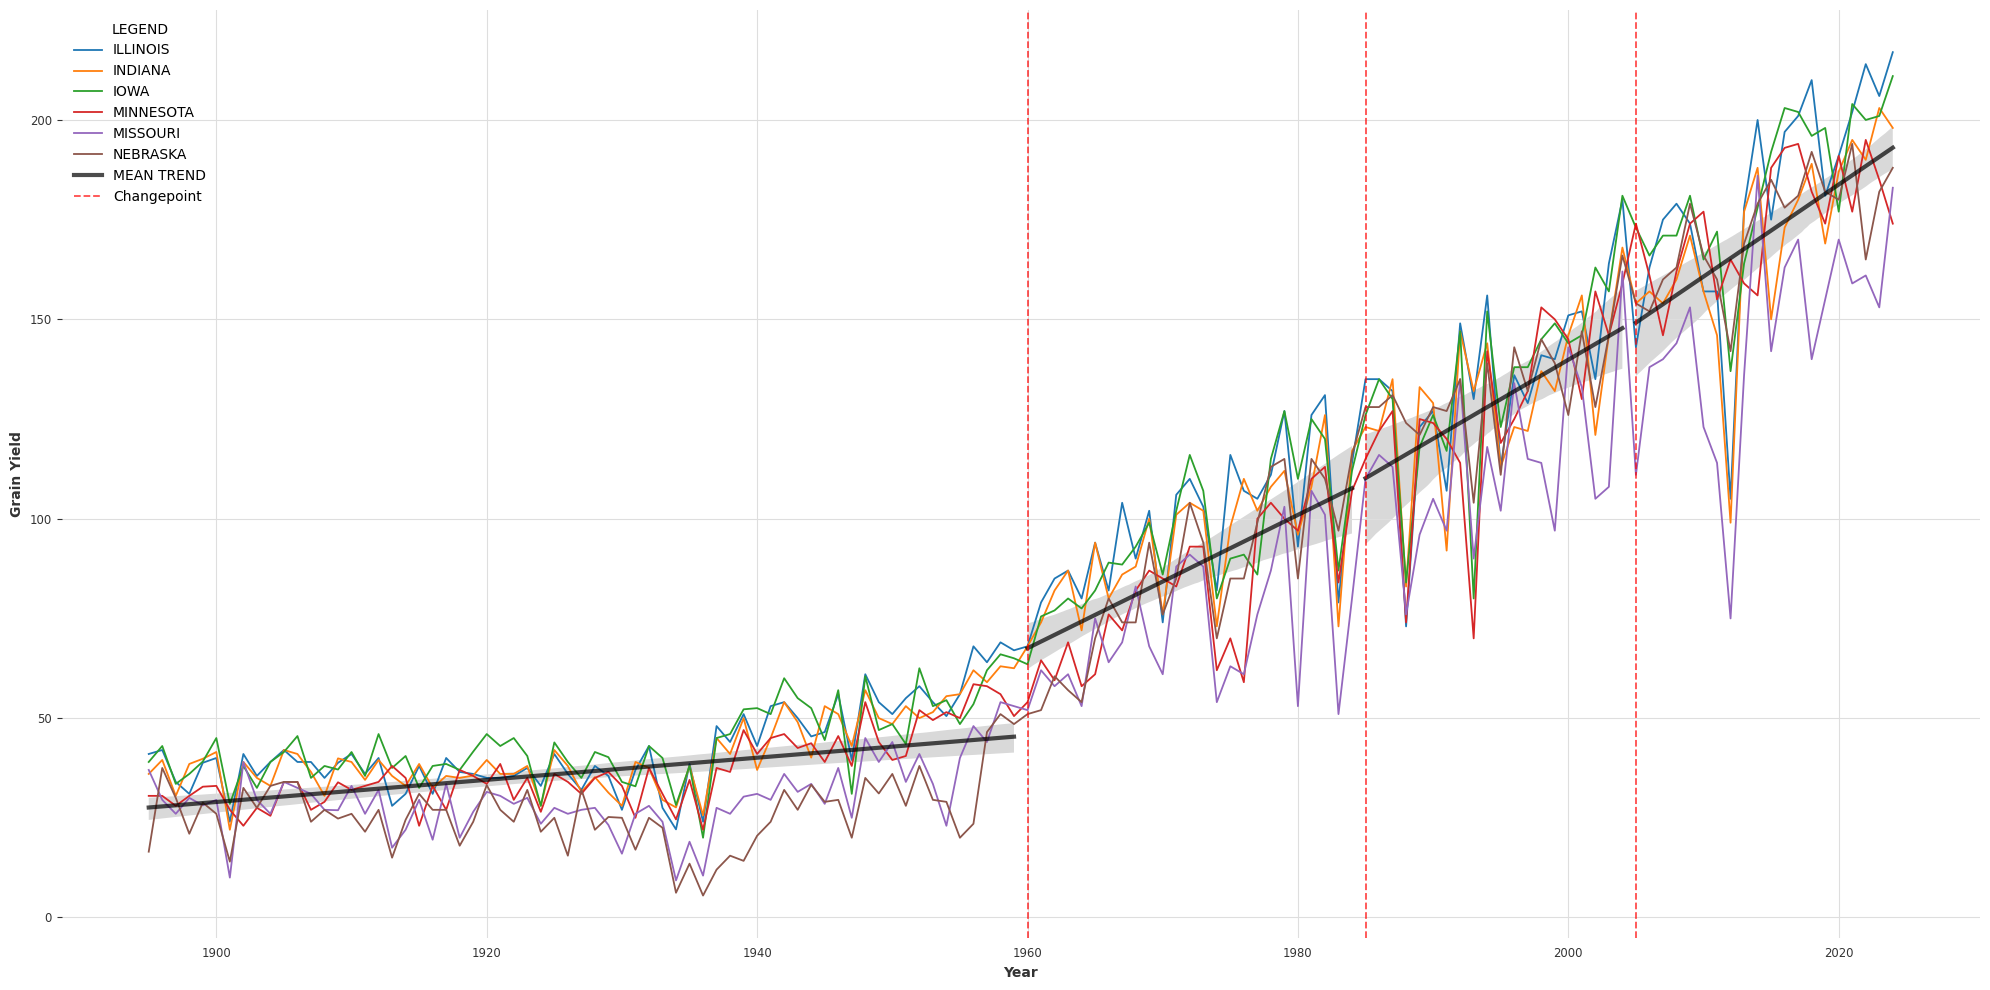

In [79]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(
    ax=ax, data=df,
    x='YEAR', y='GRAIN',
    hue='STATE', palette=list(mcolors.TABLEAU_COLORS.keys())[:len(states)]
)
for group in yield_df['GROUP'].unique():
    sns.regplot(
        ax=ax, data=yield_df[yield_df['GROUP'] == group],
        x='YEAR', y='MEAN',
        scatter=False, color='black', line_kws={'linewidth':3, 'alpha':0.7},
        label='MEAN TREND' if group == 0 else None
    )
for i, bkp_year in enumerate(yield_df[yield_df['BKP'] == 1]['YEAR']):
    print(bkp_year)
    ax.axvline(bkp_year, color='red', linestyle='--', alpha=0.7, label='Changepoint' if i == 0 else None)

ax.legend(title='LEGEND')
ax.set_xlabel('Year', fontweight='bold')
ax.set_ylabel('Grain Yield', fontweight='bold')

plt.tight_layout()
plt.savefig('../../results/analysis/bkp_tsplot.png') # file path appears as `results/analysis/bkp_tsplot.png` in `analysis.py`
plt.show()

## Coercing Stationarity

In [80]:
print('\nKPSS TEST RESULTS (H0 : GRAIN YIELD stationary around a deterministic trend):')
for group in df['GROUP'].unique():
    pvals = []
    for state in df['STATE'].unique():

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            pvals.append(
                sm.tsa.stattools.kpss(
                    x=df[(df['STATE'] == state) & (df['GROUP'] == group)]['GRAIN'].values,
                    regression='ct'
                )[1]
            )
    print(
        f'\n\tgroup: {group} | mean p-value: {np.nanmean(pvals):.4f}'
    )


KPSS TEST RESULTS (H0 : GRAIN YIELD stationary around a deterministic trend):

	group: 0 | mean p-value: 0.0115

	group: 1 | mean p-value: 0.0512

	group: 2 | mean p-value: 0.0708

	group: 3 | mean p-value: 0.1000


In [81]:
for state in df['STATE'].unique():
    for group in df['GROUP'].unique():

        lm = sm.OLS(
            endog=df[(df['STATE'] == state) & (df['GROUP'] == group)]['GRAIN'],
            exog=sm.add_constant(df[(df['STATE'] == state) & (df['GROUP'] == group)]['YEAR'])
        ).fit()
        df.loc[
            (df['STATE'] == state) & (df['GROUP'] == group),
            'GRAIN_DETRENDED'
        ] = df.loc[
            (df['STATE'] == state) & (df['GROUP'] == group),
            'GRAIN'
        ] - lm.predict(sm.add_constant(df[(df['STATE'] == state) & (df['GROUP'] == group)]['YEAR']))
        df.loc[
            (df['STATE'] == state) & (df['GROUP'] == group),
            'TREND'
        ] = lm.predict(sm.add_constant(df[(df['STATE'] == state) & (df['GROUP'] == group)]['YEAR']))

1960
1985
2005


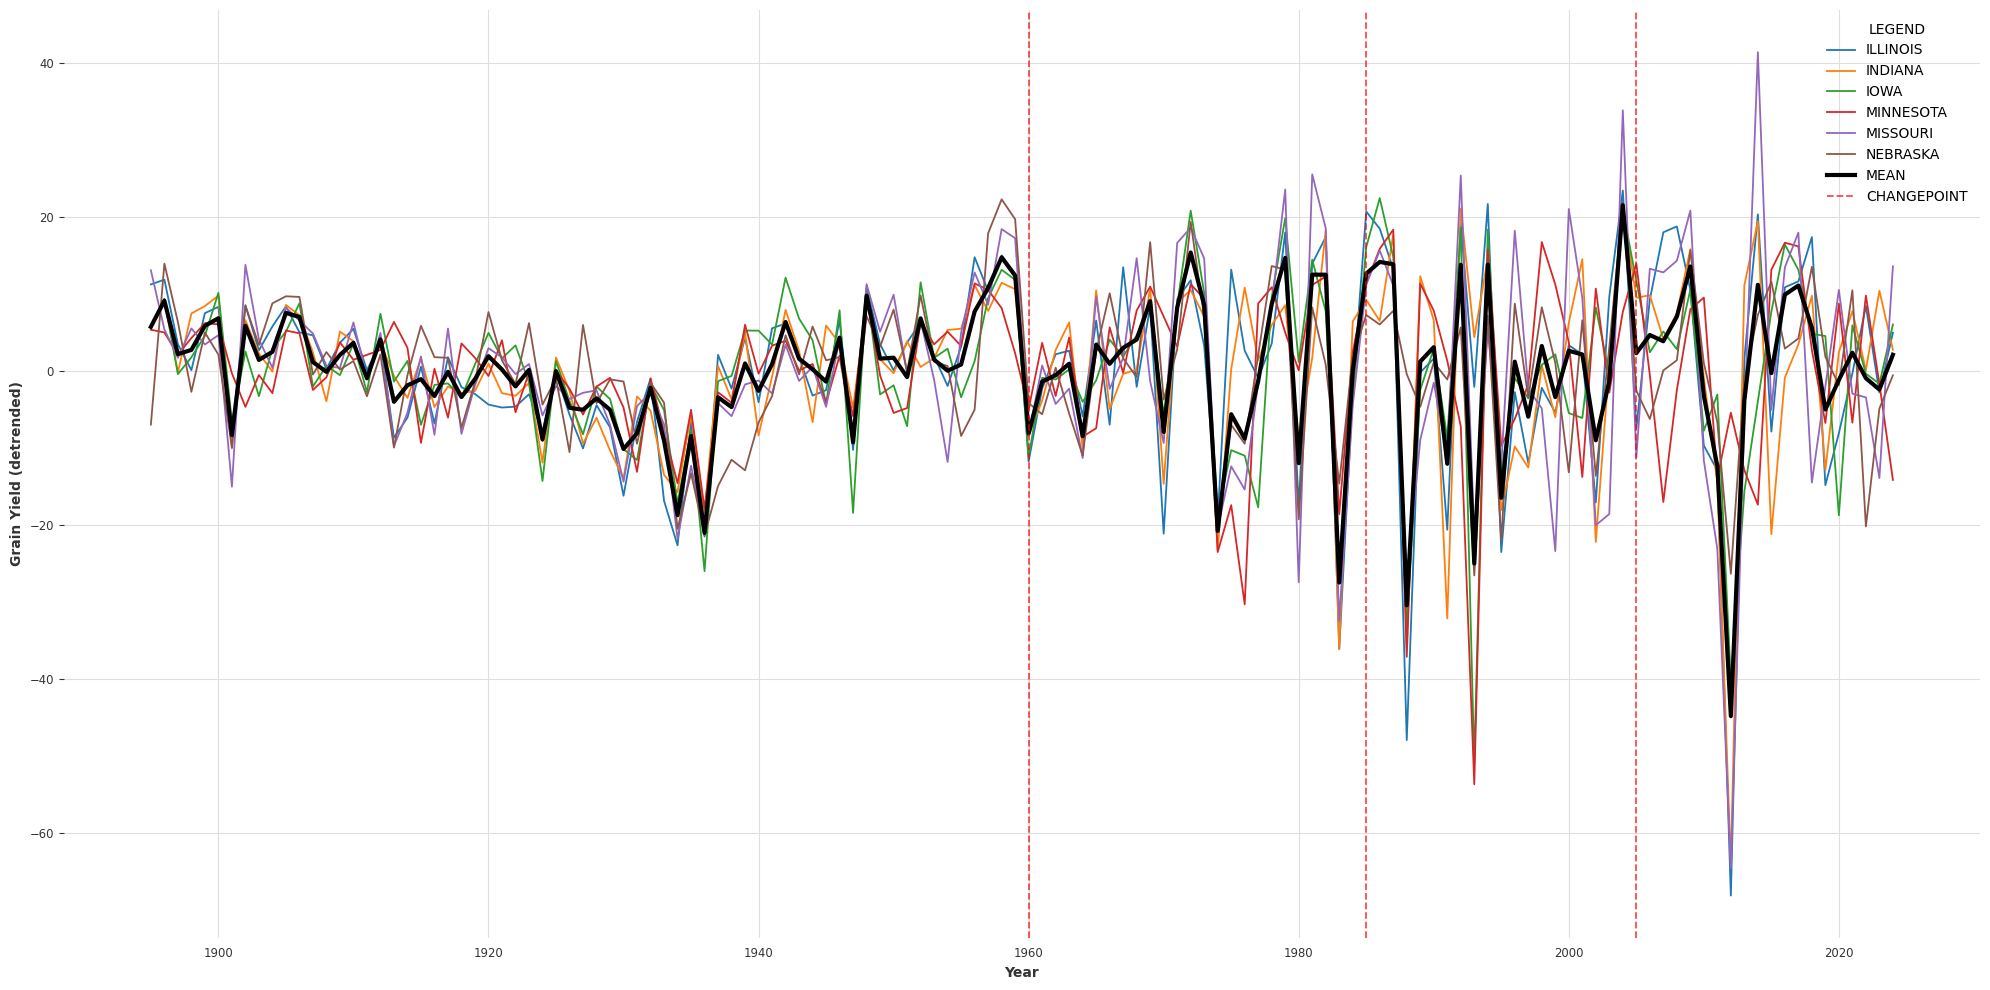

In [82]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(
    ax=ax, data=df,
    x='YEAR', y='GRAIN_DETRENDED',
    hue='STATE', palette=list(mcolors.TABLEAU_COLORS.keys())[:len(states)]
)
sns.lineplot(
    ax=ax, data=df.groupby('YEAR').agg({'GRAIN_DETRENDED':'mean'}, as_index=False),
    x='YEAR', y='GRAIN_DETRENDED',
    color='black', linewidth=3, label='MEAN'
)
for i, bkp_year in enumerate(yield_df[yield_df['BKP'] == 1]['YEAR']):
    print(bkp_year)
    ax.axvline(bkp_year, color='red', linestyle='--', alpha=0.7, label='CHANGEPOINT' if i == 0 else None)

ax.legend(title='LEGEND')
ax.set_xlabel('Year', fontweight='bold')
ax.set_ylabel('Grain Yield (detrended)', fontweight='bold')

plt.tight_layout()
# plt.savefig('../../results/analysis/____.png') # file path appears as `results/analysis/____.png` in `analysis.py`
plt.show()

In [83]:
print('\nKPSS TEST RESULTS (H0 : GRAIN YIELD DETRENDED stationary):')
for group in df['GROUP'].unique():
    pvals = []
    for state in df['STATE'].unique():

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            pvals.append(
                sm.tsa.stattools.kpss(
                    x=df[(df['STATE'] == state) & (df['GROUP'] == group)]['GRAIN_DETRENDED'].values
                )[1]
            )
    print(
        f'\n\tgroup: {group} | mean p-value: {np.nanmean(pvals):.4f}'
    )

print('\nADF TEST RESULTS (H0 : GRAIN YIELD DETRENDED non-stationary):')
for group in df['GROUP'].unique():
    pvals = []
    for state in df['STATE'].unique():

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            pvals.append(
                sm.tsa.stattools.adfuller(
                    x=df[(df['STATE'] == state) & (df['GROUP'] == group)]['GRAIN_DETRENDED'].values
                )[1]
            )
    print(
        f'\n\tgroup: {group} | mean p-value: {np.nanmean(pvals):.4f}'
    )


KPSS TEST RESULTS (H0 : GRAIN YIELD DETRENDED stationary):

	group: 0 | mean p-value: 0.1000

	group: 1 | mean p-value: 0.0879

	group: 2 | mean p-value: 0.1000

	group: 3 | mean p-value: 0.1000

ADF TEST RESULTS (H0 : GRAIN YIELD DETRENDED non-stationary):

	group: 0 | mean p-value: 0.2236

	group: 1 | mean p-value: 0.2082

	group: 2 | mean p-value: 0.5853

	group: 3 | mean p-value: 0.2710


Text(0.5, 1.0, 'Grain Yield (detrended)')

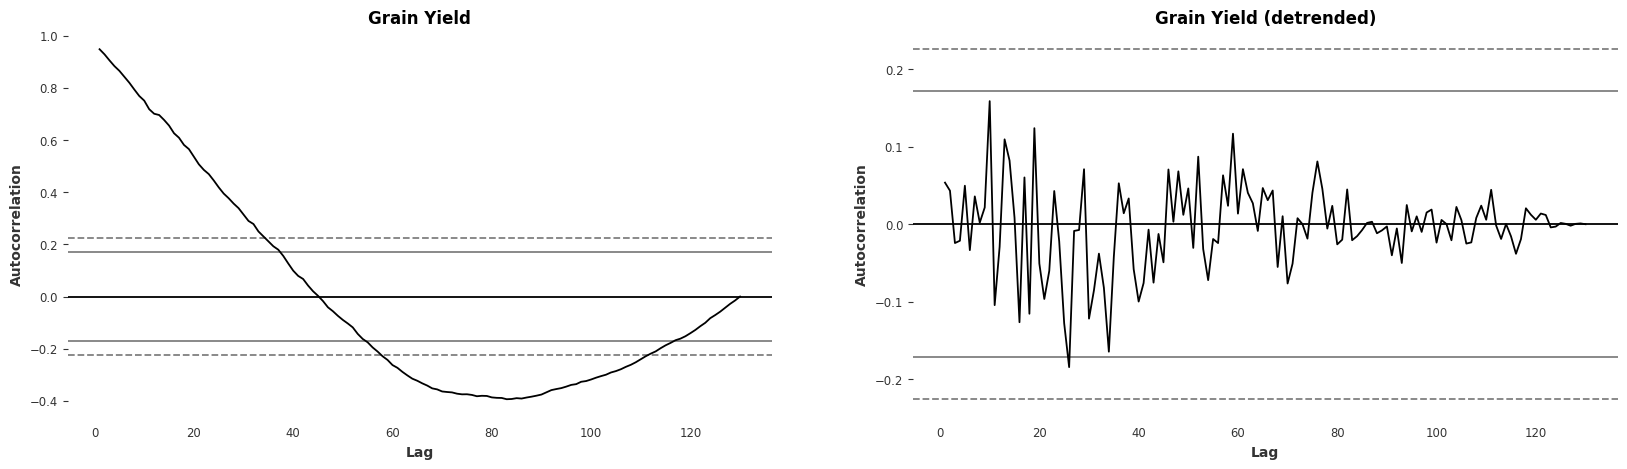

In [84]:
_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

pd.plotting.autocorrelation_plot(df.groupby('YEAR').agg({'GRAIN':'mean'})['GRAIN'], ax=ax1)
ax1.set_title('Grain Yield', fontweight='bold')

pd.plotting.autocorrelation_plot(df.groupby('YEAR').agg({'GRAIN_DETRENDED':'mean'})['GRAIN_DETRENDED'], ax=ax2)
ax2.set_title('Grain Yield (detrended)', fontweight='bold')

## Correlation Analysis

In [86]:
features = ['TEMP_MEAN', 'TEMP_MIN', 'TEMP_MAX', 'PCP_SUM', 'PDSI_MEAN']

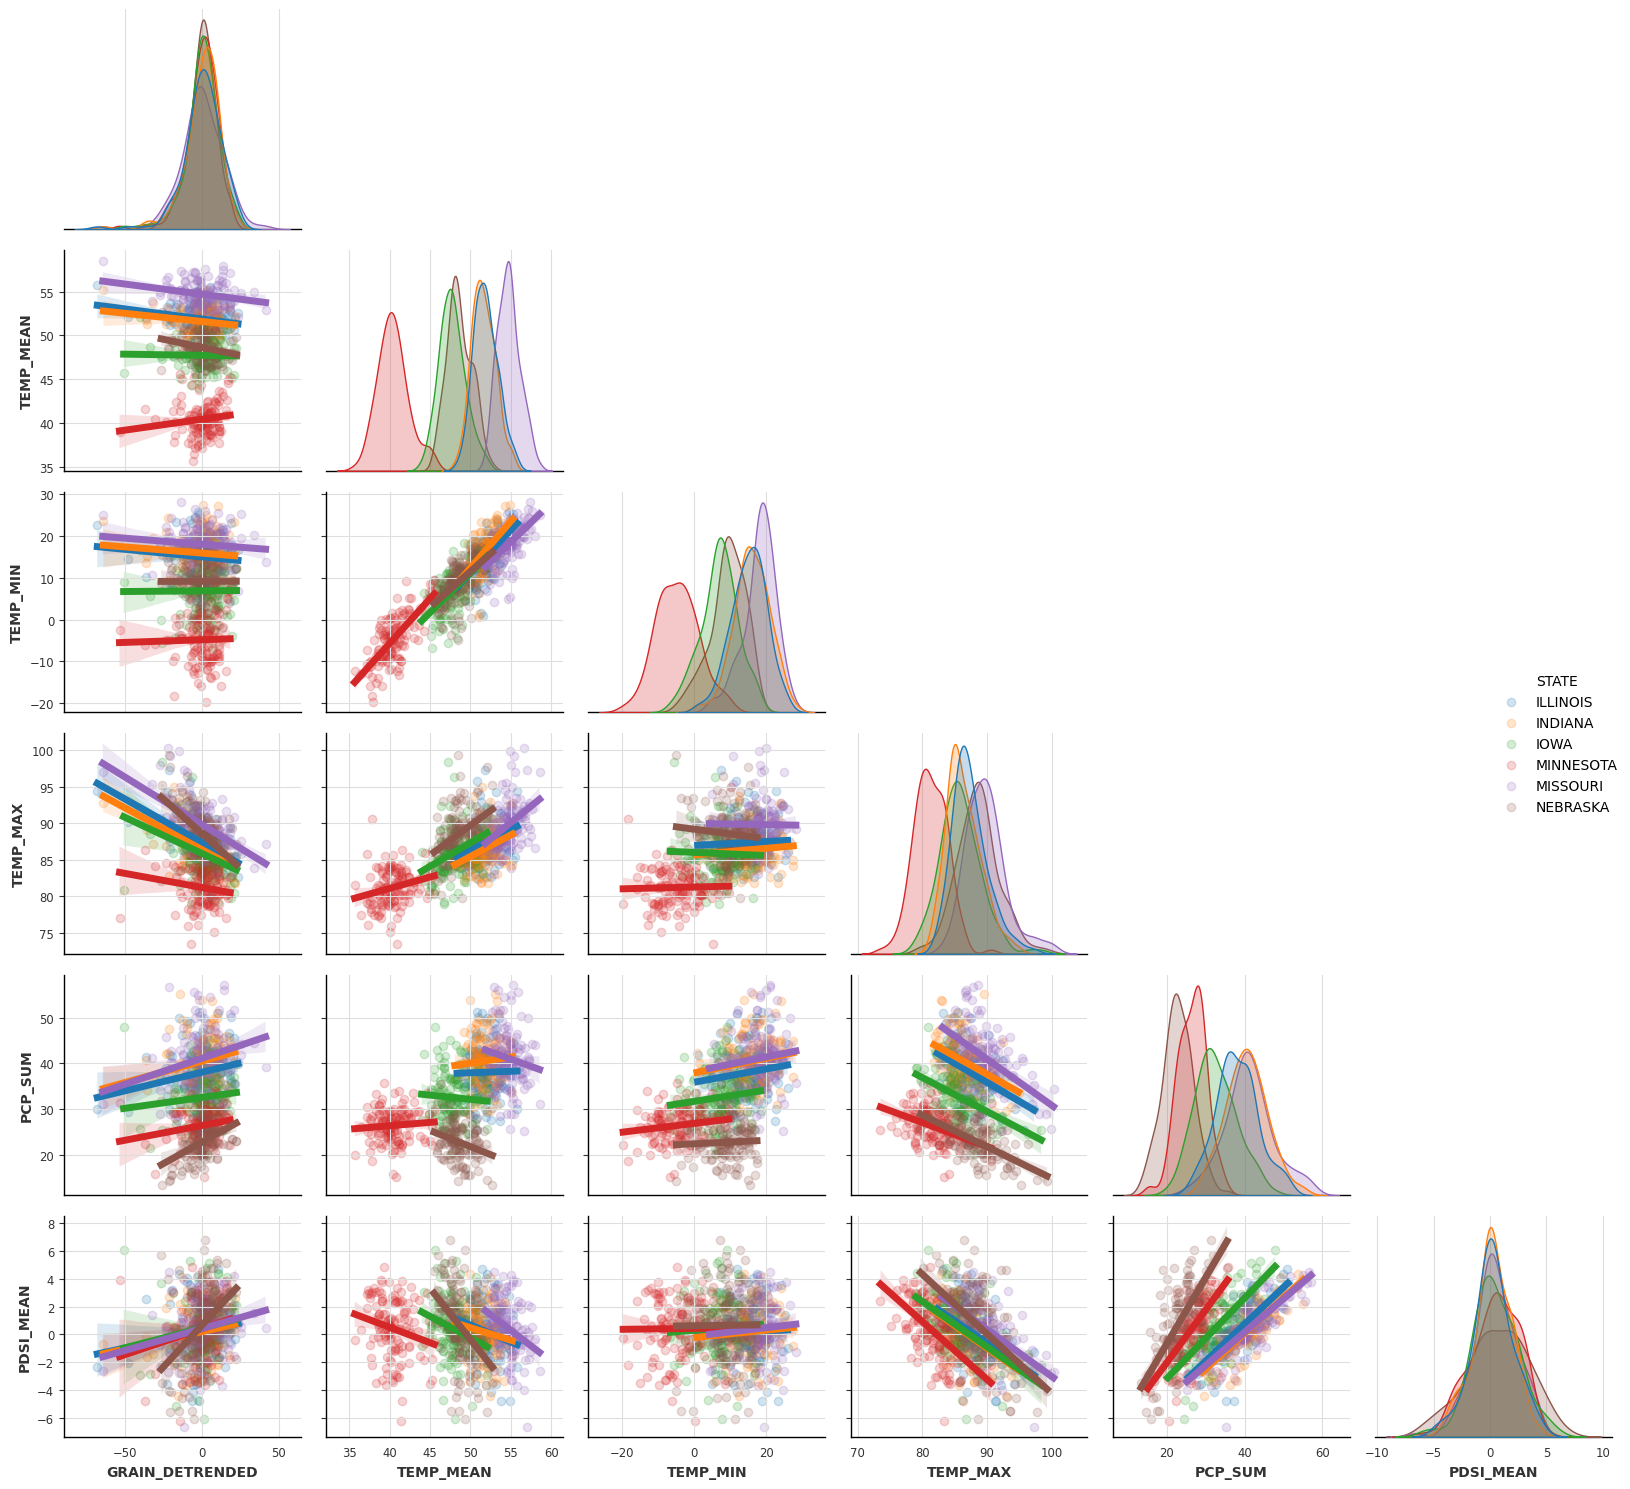

In [93]:
cols = ['GRAIN_DETRENDED'] + features
sns.pairplot(
    df[cols + ['STATE']],
    corner=True, kind='reg', diag_kind='kde',
    hue='STATE', palette=list(mcolors.TABLEAU_COLORS.keys())[:len(cols)],
    plot_kws={
        'line_kws':{'linewidth':5},
        'scatter_kws':{'alpha':0.2}
    }
)
plt.tight_layout()
plt.savefig('../../results/analysis/pairplot_reg.png') # file path appears as `results/analysis/pairplot_reg.png` in `analysis.py`
plt.show()

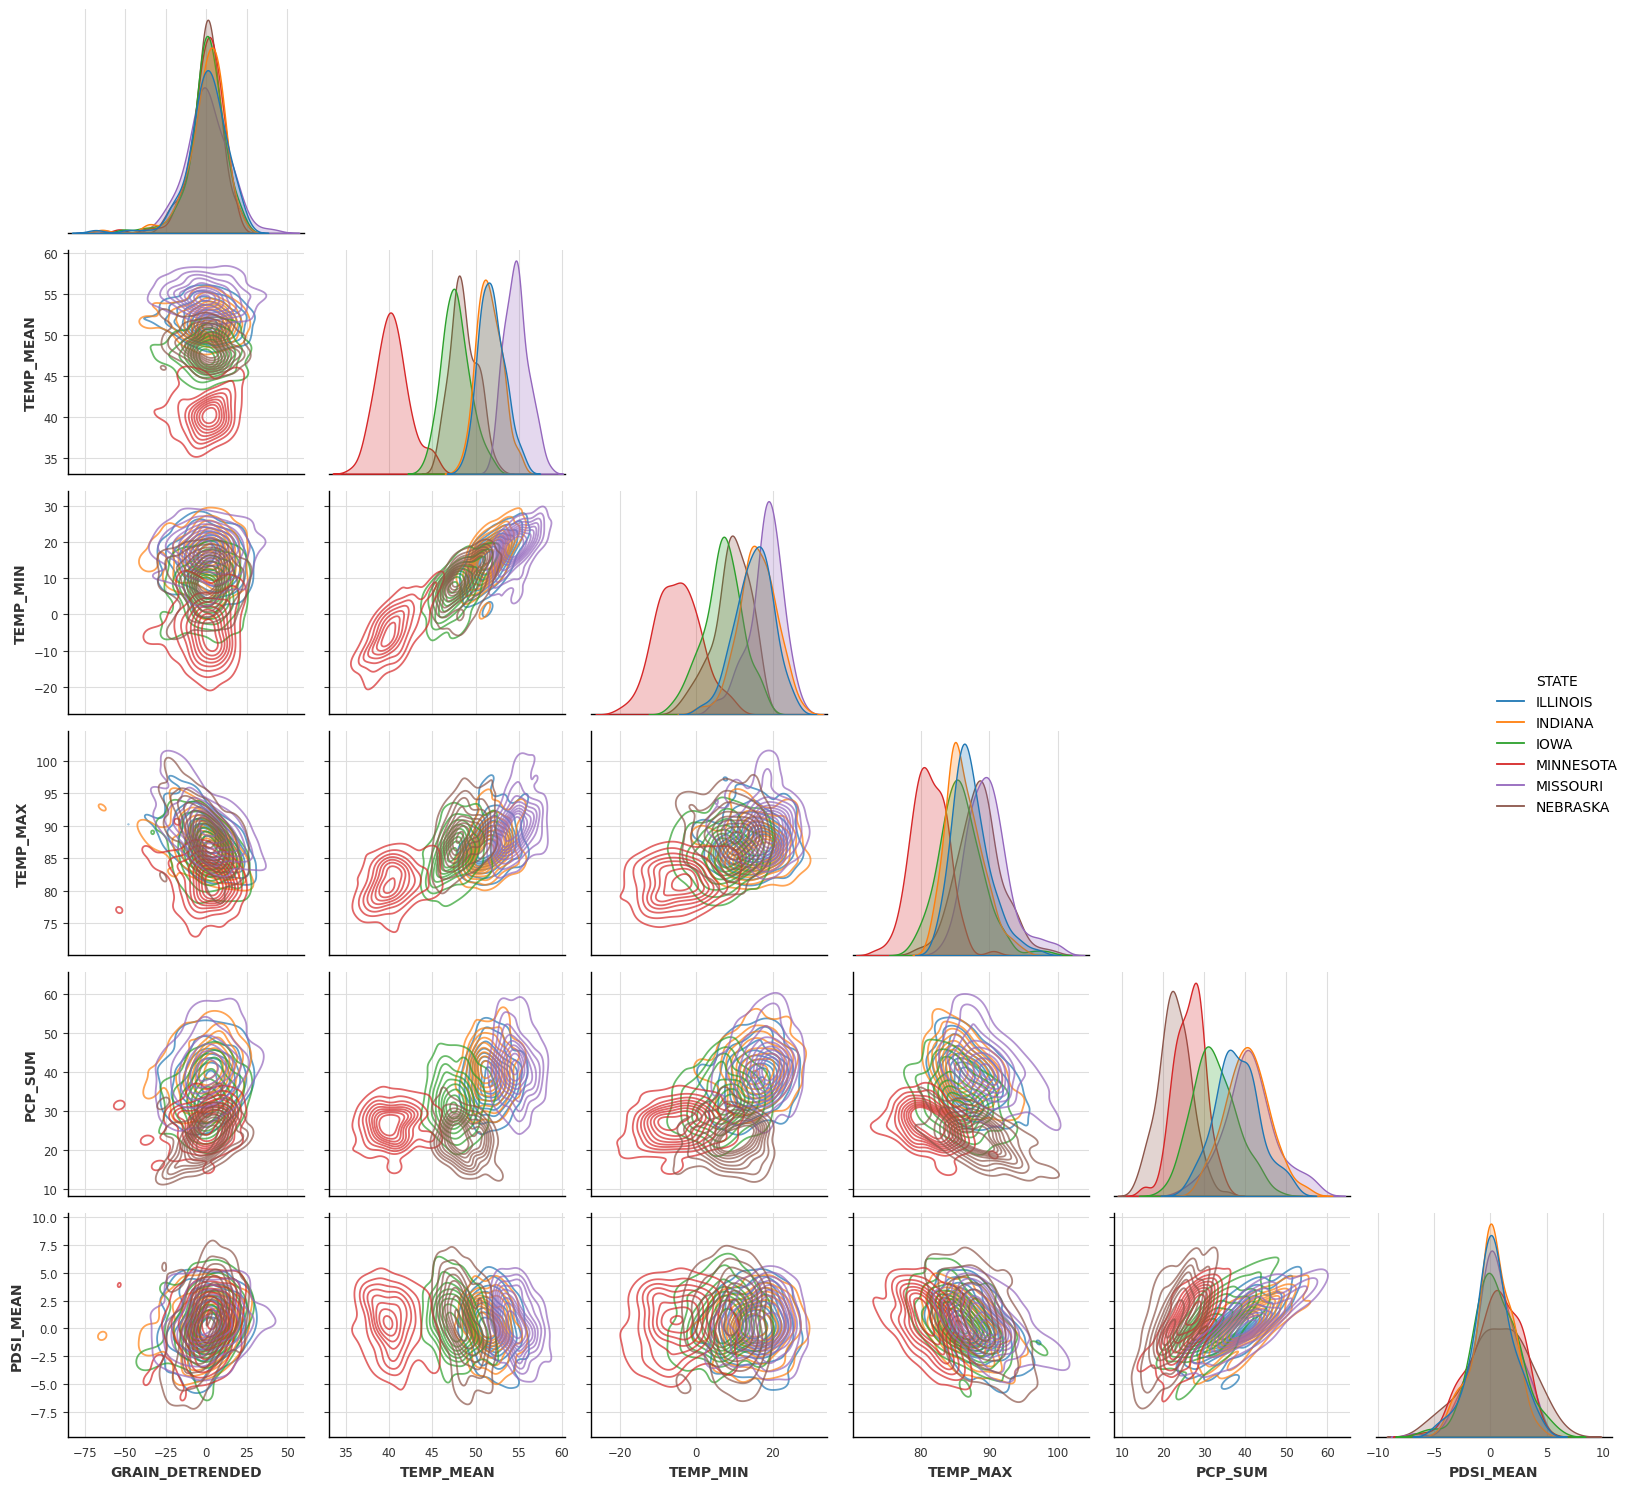

In [94]:
sns.pairplot(
    df[cols + ['STATE']],
    corner=True, kind='kde', diag_kind='kde',
    hue='STATE', palette=list(mcolors.TABLEAU_COLORS.keys())[:len(cols)],
    plot_kws={'multiple':'fill', 'alpha':0.7}
)
plt.tight_layout()
plt.savefig('../../results/analysis/pairplot_kde.png') # file path appears as `results/analysis/pairplot_kde.png` in `analysis.py`
plt.show()

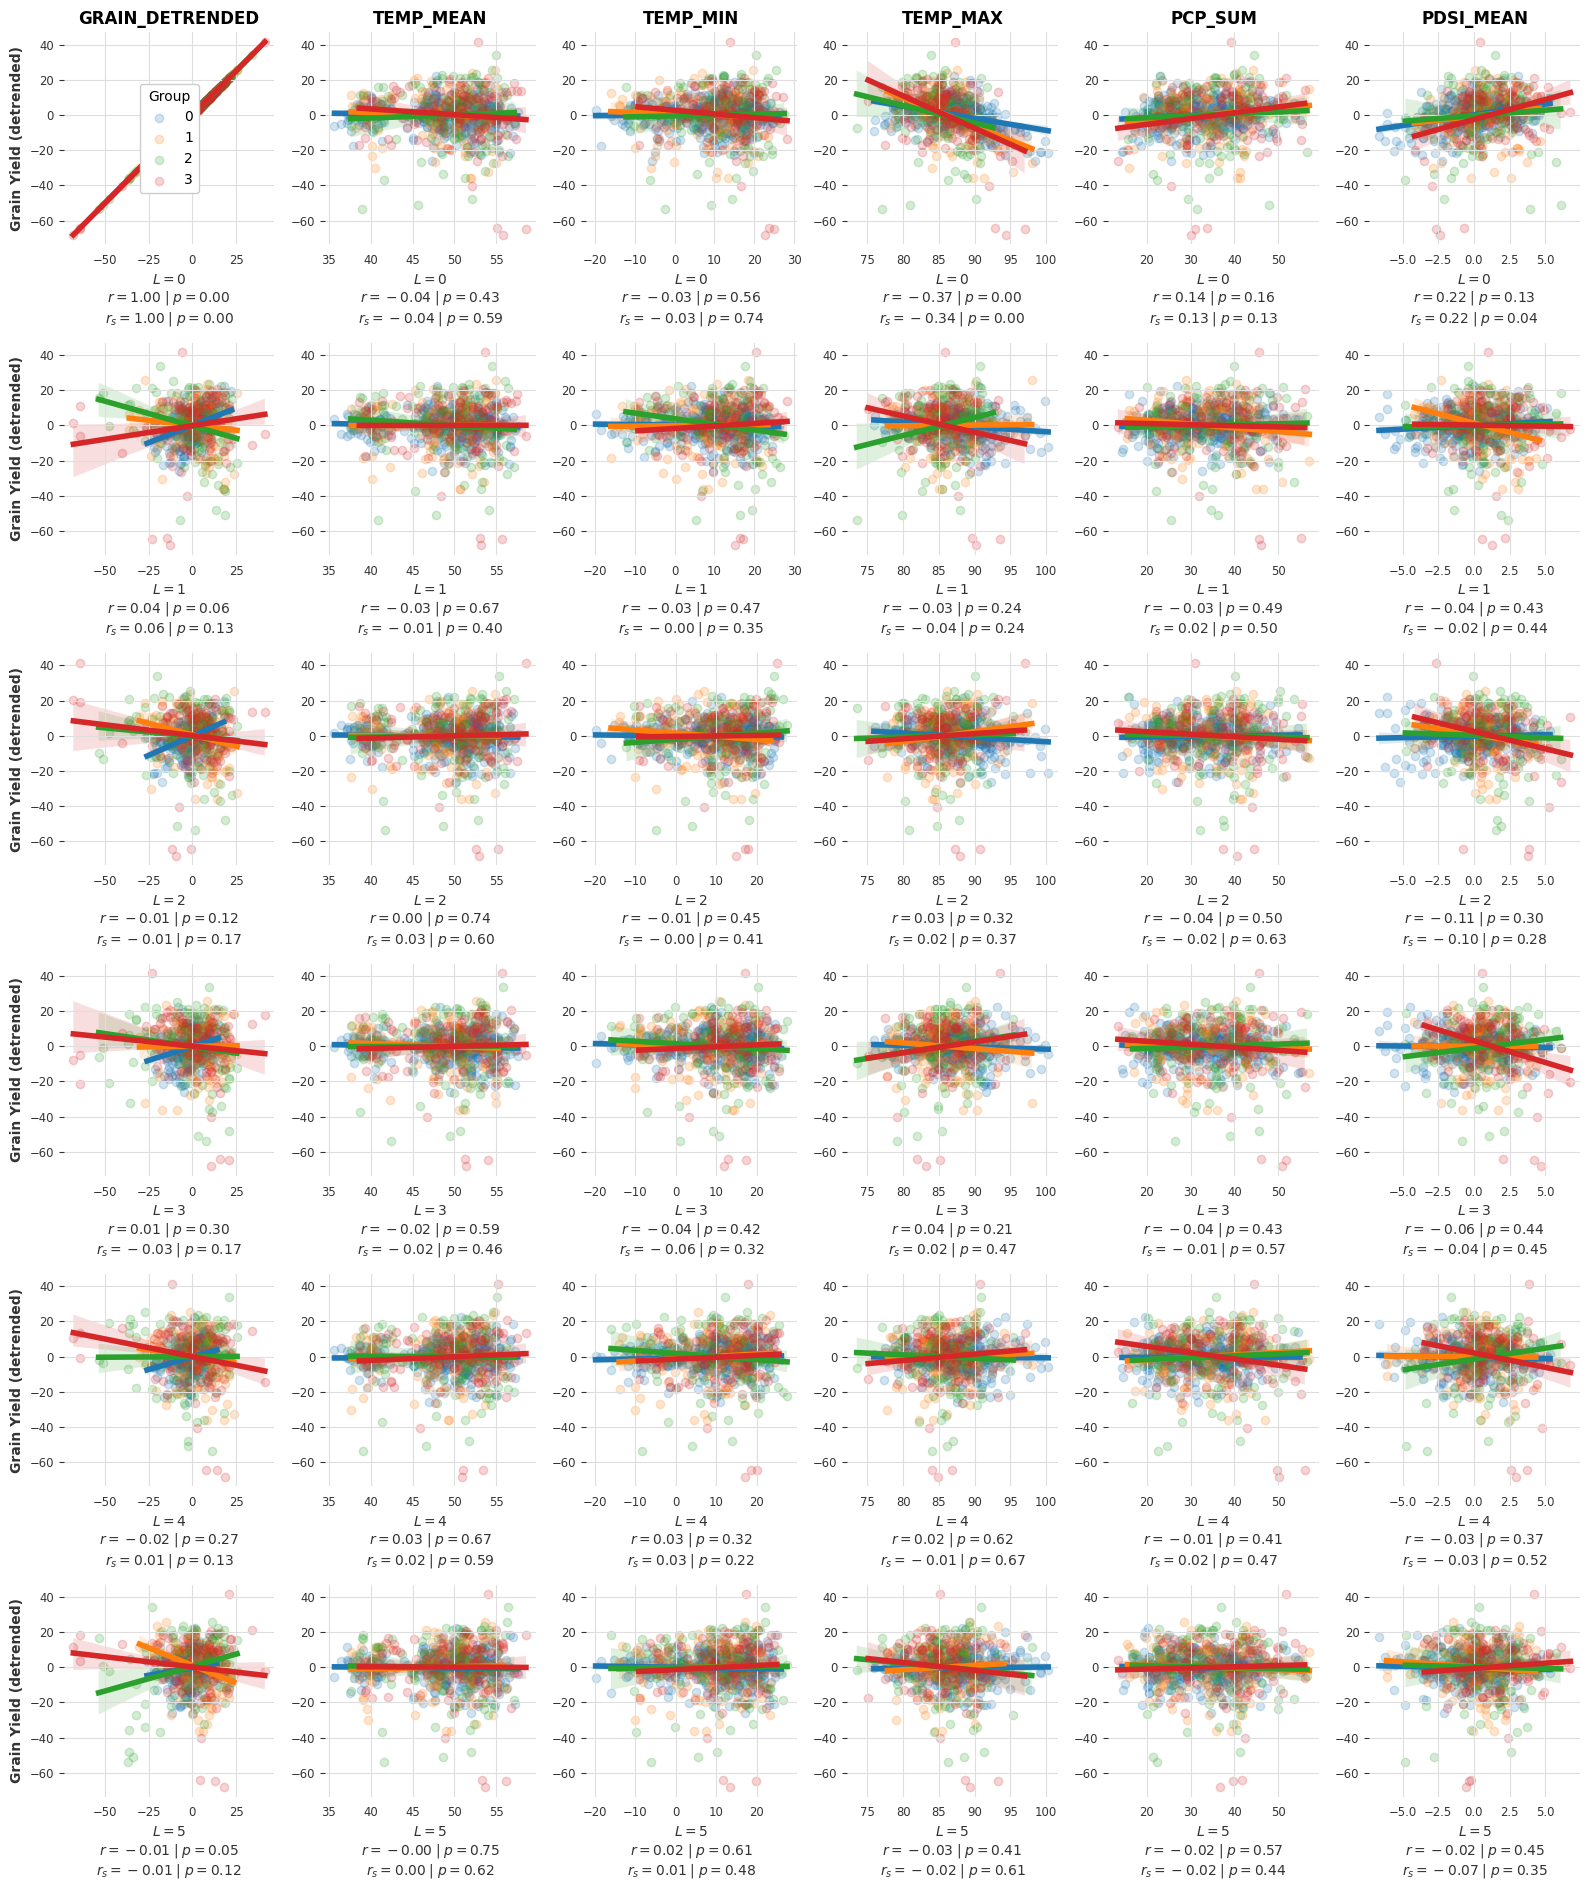

In [99]:
lag_dict = {}
for col in cols:
    df_lagged = df.copy(deep=True)
    for lag in range(1, 6):
        df_lagged[f'{col}_LAG{lag}'] = df_lagged.groupby('STATE')[col].shift(lag)
    lag_dict[col] = df_lagged

fig, axes = plt.subplots(nrows=6, ncols=len(cols), figsize=(16, 19))
for i, col in enumerate(cols):
    data = lag_dict[col]
    for lag in range(6):
        ax = axes[lag, i]
        group_values = {}
        for group, color in zip(data['GROUP'].unique(), list(mcolors.TABLEAU_COLORS.keys())[:len(data['GROUP'].unique())]):
            pearson_stat, pearson_p = stats.pearsonr(
                    x=data[data['GROUP'] == group].dropna()[f'{col}_LAG{lag}' if lag != 0 else col],
                    y=data[data['GROUP'] == group].dropna()['GRAIN_DETRENDED']
                )
            spearman_stat, spearman_p = stats.spearmanr(
                    a=data[data['GROUP'] == group].dropna()[f'{col}_LAG{lag}' if lag != 0 else col],
                    b=data[data['GROUP'] == group].dropna()['GRAIN_DETRENDED']
                )
            group_values[group] = (pearson_stat, pearson_p, spearman_stat, spearman_p)
            sns.regplot(
                ax=ax,
                data=data[data['GROUP'] == group], x=f'{col}_LAG{lag}' if lag != 0 else col, y='GRAIN_DETRENDED',
                scatter_kws={'alpha':0.2}, line_kws={'linewidth':4},
                label=group, color=color
            )
        ax.set_title(col if lag == 0 else '', fontweight='bold')
        ax.set_xlabel(
            f'$L = {lag}$\n'
            f'$r = {np.nanmean([v[0] for v in group_values.values()]):.2f} \;|\; p = {np.nanmean([v[1] for v in group_values.values()]):.2f}$\n'
            f'$r_s = {np.nanmean([v[2] for v in group_values.values()]):.2f} \;|\; p = {np.nanmean([v[3] for v in group_values.values()]):.2f}$'
        )
        ax.set_ylabel('Grain Yield (detrended)' if i == 0 else '', fontweight='bold')
        if col == 'GRAIN_DETRENDED' and lag == 0:
            ax.legend(title='Group', loc='center', frameon=True, fancybox=True, framealpha=1)
plt.tight_layout()
plt.savefig('../../results/analysis/lag_correlations.png') # file path appears as `results/analysis/lag_correlations.png` in `analysis.py`
plt.show()

In [100]:
df.to_csv('../../data/processed/analysis.csv', index=False) # file path appears as `data/processed/analysis.csv` in `analysis.py`